<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
### <font color='blue'>Modelagem de Séries Temporais e Real-Time Analytics com Apache Spark e Databricks</font>
### <font color='blue'>Projeto 1 - Tarefa 6</font>
### <font color='blue'>Prevendo Usuários Ativos em Um Web Site</font>

## Instalando e Carregando os Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

In [2]:
# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
from matplotlib.pyplot import figure

# Imports para modelagem preditiva
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Imports para métricas e performance do modelo
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Filtrando warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## Carregando e Compreendendo os Dados

In [4]:
# Carrega os dados
df_dsa = pd.read_csv("dataset.csv")
df_dsa_novos_dados = pd.read_csv("novos_dados.csv")

### Explorando a Série

In [5]:
# Shape
df_dsa.shape

(18288, 3)

In [6]:
# Primeiros registros
df_dsa.head()

,id,data,usuarios_ativos
0,0,25-08-2021 00:00,8
1,1,25-08-2021 01:00,2
2,2,25-08-2021 02:00,6
3,3,25-08-2021 03:00,2
4,4,25-08-2021 04:00,2


In [7]:
# Últimos registros
df_dsa.tail()

,id,data,usuarios_ativos
18283,18283,25-09-2023 19:00,868
18284,18284,25-09-2023 20:00,732
18285,18285,25-09-2023 21:00,702
18286,18286,25-09-2023 22:00,580
18287,18287,25-09-2023 23:00,534


In [8]:
# Tipos de dados
df_dsa.dtypes

id                  int64
data               object
usuarios_ativos     int64
dtype: object

### Explorando os Novos Dados

In [9]:
# Shape
df_dsa_novos_dados.shape

(5112, 2)

In [10]:
# Primeiros registros
df_dsa_novos_dados.head()

,id,data
0,18288,26-09-2023 00:00
1,18289,26-09-2023 01:00
2,18290,26-09-2023 02:00
3,18291,26-09-2023 03:00
4,18292,26-09-2023 04:00


In [11]:
# Últimos registros
df_dsa_novos_dados.tail()

,id,data
5107,23395,26-04-2024 19:00
5108,23396,26-04-2024 20:00
5109,23397,26-04-2024 21:00
5110,23398,26-04-2024 22:00
5111,23399,26-04-2024 23:00


In [12]:
# Tipos
df_dsa_novos_dados.dtypes

id       int64
data    object
dtype: object

## Preparação dos Dados

In [13]:
# Converte a coluna de data para o tipo correto
df_dsa['data'] = pd.to_datetime(df_dsa.data, format = '%d-%m-%Y %H:%M')

In [14]:
# Verifica os tipos de dados
df_dsa.dtypes

id                          int64
data               datetime64[ns]
usuarios_ativos             int64
dtype: object

In [15]:
# Converte a coluna de data para o tipo correto
df_dsa_novos_dados['data'] = pd.to_datetime(df_dsa_novos_dados.data, format = '%d-%m-%Y %H:%M')

In [16]:
# Verifica os tipos de dados
df_dsa_novos_dados.dtypes

id               int64
data    datetime64[ns]
dtype: object

In [17]:
# Vejamos como ficou o dataset
df_dsa.head(5)

,id,data,usuarios_ativos
0,0,2021-08-25 00:00:00,8
1,1,2021-08-25 01:00:00,2
2,2,2021-08-25 02:00:00,6
3,3,2021-08-25 03:00:00,2
4,4,2021-08-25 04:00:00,2


In [18]:
# Definimos o índice do dataset
df_dsa.index = df_dsa['data']

In [19]:
# Removemos a coluna ID, pois ela não é relevante neste caso
df_dsa.drop('id', axis = 1, inplace = True)

In [20]:
# Removemos a coluna data, pois ela não é relevante neste caso
df_dsa.drop('data', axis = 1, inplace = True)

In [21]:
# Variável target 
target = df_dsa['usuarios_ativos']

In [22]:
# Vejamos como ficou o dataset
df_dsa.head(5)

,usuarios_ativos
data,
2021-08-25 00:00:00,8
2021-08-25 01:00:00,2
2021-08-25 02:00:00,6
2021-08-25 03:00:00,2
2021-08-25 04:00:00,2


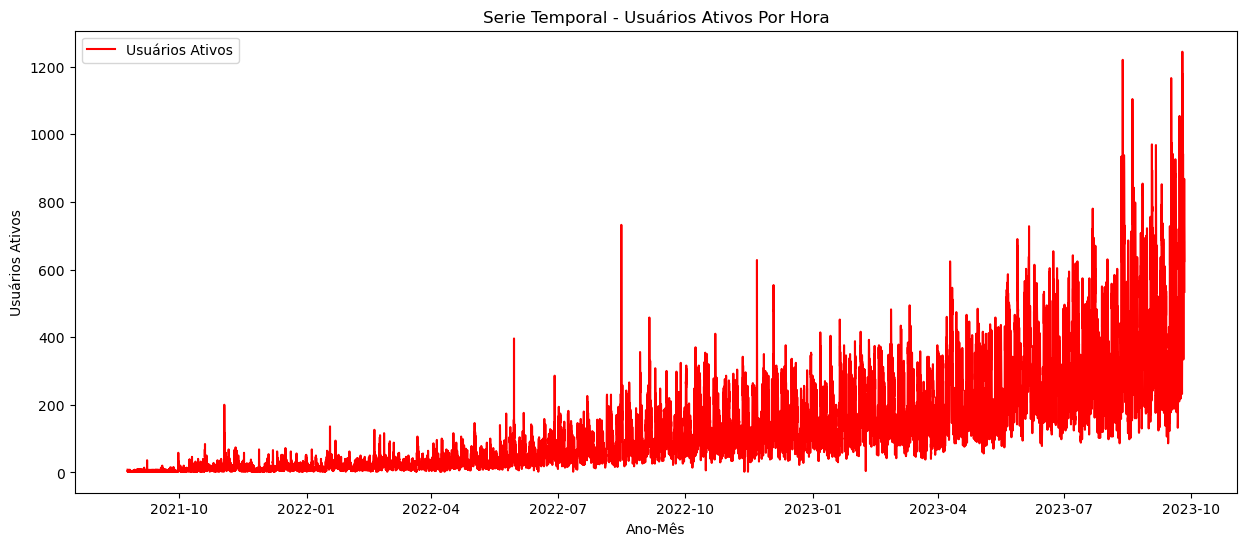

In [23]:
# Plot
figure(figsize = (15, 6))
plt.title("Serie Temporal - Usuários Ativos Por Hora")
plt.plot(target, label = "Usuários Ativos", color = 'red')
plt.xlabel("Ano-Mês")
plt.ylabel("Usuários Ativos")
plt.legend(loc = "best")
plt.show();

Percebemos que há claramente uma tendência de aumento no número de usuários ativos ao longo do tempo. 

## Pré-Processamento dos Dados

Vamos agora dividir os dados de treino em duas amostras, treino e validação. Usamos os dados de treino para treinar o modelo e os dados de validação avalair a performance do modelo.

Observe que os registros são separados em ordem cronológica, diferentemente o que fazemos com modelos de Machine Learning que não consideram a data como indexador (Para esses modelos queremos a divisão dos dados de forma aleatória). Em séries temporais, queremos a divisão em ordem cronológica, já que o tempo é um elemento de informação dos dados.

In [24]:
df_dsa.head()

,usuarios_ativos
data,
2021-08-25 00:00:00,8
2021-08-25 01:00:00,2
2021-08-25 02:00:00,6
2021-08-25 03:00:00,2
2021-08-25 04:00:00,2


In [25]:
# Os dados de treino serão divididos em dados de treino e validação
df_treino = df_dsa.iloc[0:16057]
df_valid = df_dsa.iloc[16058:]

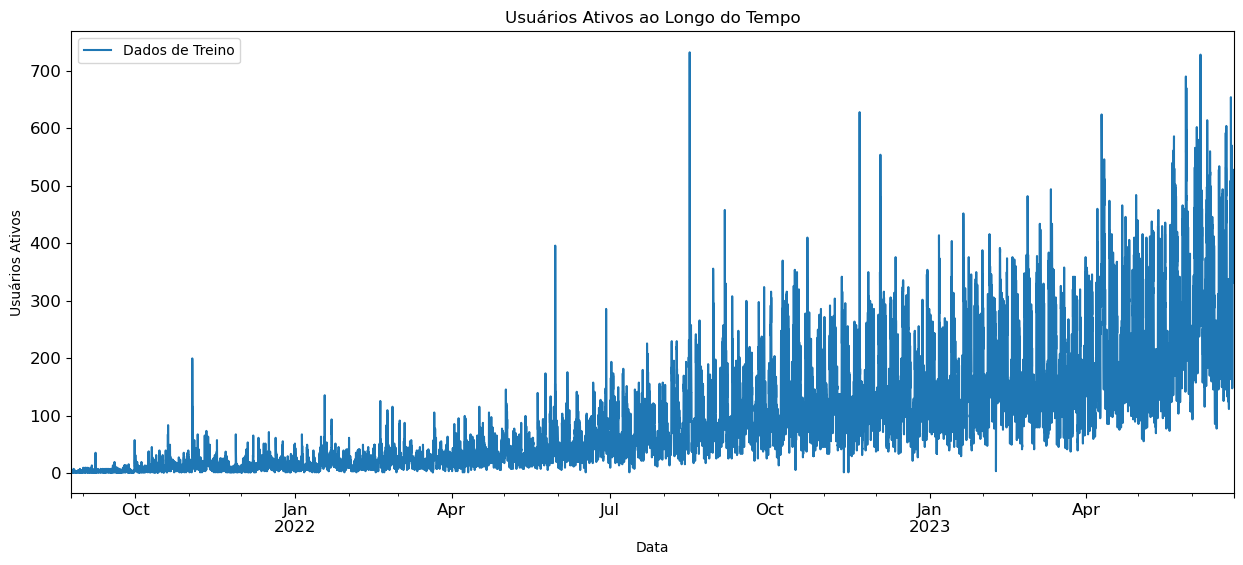

In [26]:
# Plot
figure(figsize = (15, 6))
df_treino.usuarios_ativos.plot(title = 'Usuários Ativos ao Longo do Tempo', 
                               fontsize = 12, 
                               label = 'Dados de Treino') 
plt.xlabel("Data") 
plt.ylabel("Usuários Ativos") 
plt.legend(loc = 'best') 
plt.show()

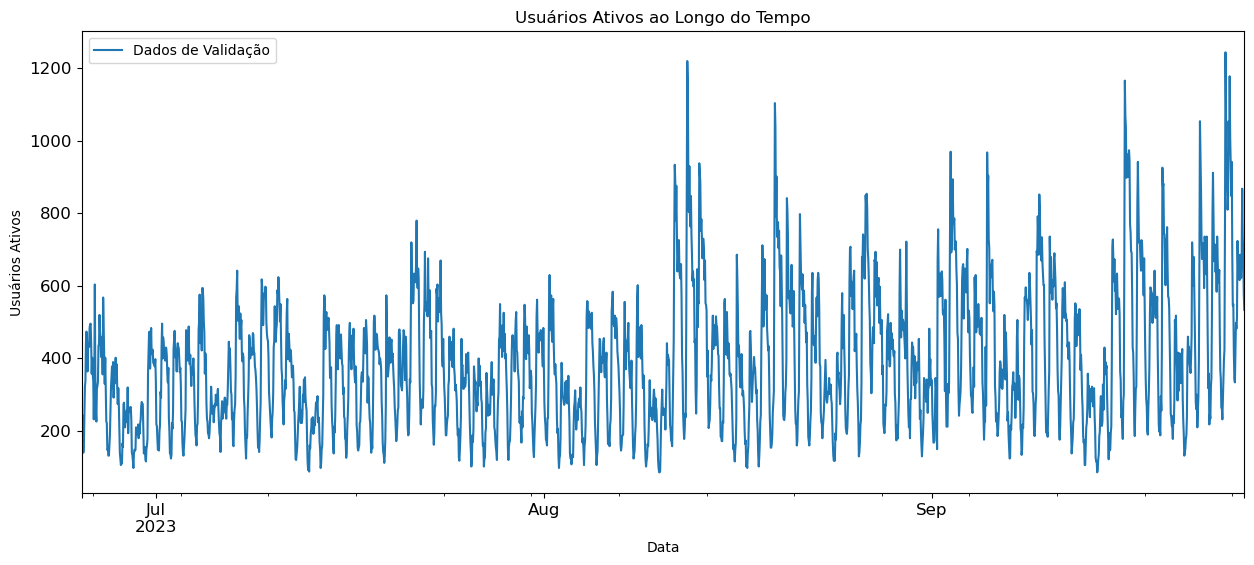

In [27]:
# Plot
figure(figsize = (15, 6))
df_valid.usuarios_ativos.plot(title = 'Usuários Ativos ao Longo do Tempo', 
                              fontsize = 12, 
                              label = 'Dados de Validação') 
plt.xlabel("Data") 
plt.ylabel("Usuários Ativos") 
plt.legend(loc = 'best') 
plt.show()

In [28]:
# Função para testar a estacionaridade
def dsa_testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    
    # Plot
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

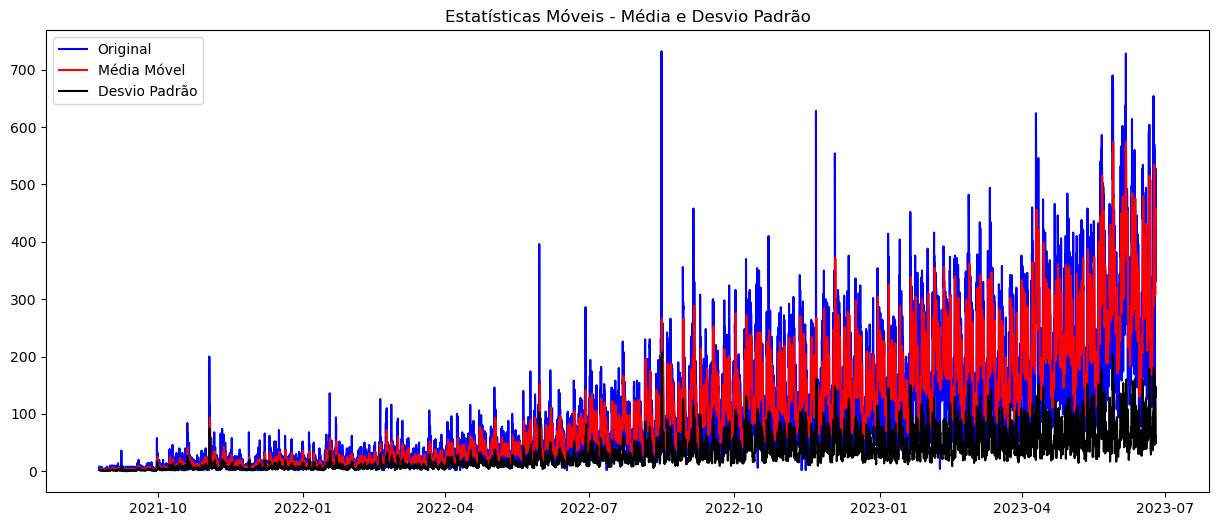


Resultado do Teste Dickey-Fuller:

Estatística do Teste               -5.038033
Valor-p                             0.000019
Número de Lags Consideradas        43.000000
Número de Observações Usadas    16013.000000
Valor Crítico (1%)                 -3.430758
Valor Crítico (5%)                 -2.861721
Valor Crítico (10%)                -2.566866
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [29]:
# Vamos testar a estacionaridade da série antes de qualquer transformação
figure(figsize = (15, 6))
dsa_testa_estacionaridade(df_treino)

## Forecasting - Modelagem Preditiva Para Séries Temporais

Criaremos alguns modelos para este problema que temos em mãos, aumentando o grau de complexidade a cada versão.

A primeira versão será a mais simples possível, que usaremos como benchmark.

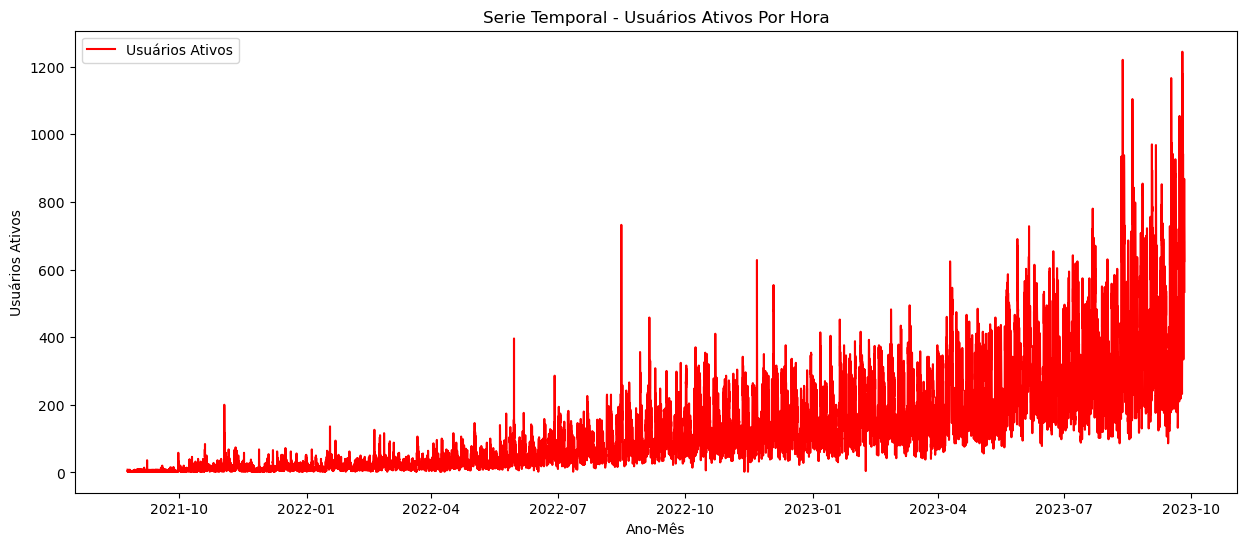

In [30]:
# Plot
figure(figsize = (15, 6))
plt.title("Serie Temporal - Usuários Ativos Por Hora")
plt.plot(target, label = "Usuários Ativos", color = 'red')
plt.xlabel("Ano-Mês")
plt.ylabel("Usuários Ativos")
plt.legend(loc = "best")
plt.show();

### Implementando a Estratégia 1 de Forecasting - Método Naive

Técnica de estimativa na qual os dados reais do último período são usados como previsão desse período, sem ajustá-los ou tentar estabelecer fatores causais. É usado apenas para comparação com as previsões geradas pelas melhores técnicas (sofisticadas).

Naive = ingênuo

Não há técnica avançada aqui e apenas usamos como ponto de partida. Qualquer modelo mais avançado deve apresentar resultados superiores ao Método Naive.

In [31]:
type(df_treino)

pandas.core.frame.DataFrame

In [32]:
df_treino.head()

,usuarios_ativos
data,
2021-08-25 00:00:00,8
2021-08-25 01:00:00,2
2021-08-25 02:00:00,6
2021-08-25 03:00:00,2
2021-08-25 04:00:00,2


In [33]:
df_treino.tail()

,usuarios_ativos
data,
2023-06-24 20:00:00,444
2023-06-24 21:00:00,406
2023-06-24 22:00:00,352
2023-06-24 23:00:00,390
2023-06-25 00:00:00,332


In [34]:
# Criamos um array com os valores da variável target em treino
array_usuarios_ativos_treino = np.asarray(df_treino.usuarios_ativos)

In [35]:
type(array_usuarios_ativos_treino)

numpy.ndarray

In [36]:
array_usuarios_ativos_treino

array([  8,   2,   6, ..., 352, 390, 332])

In [37]:
array_usuarios_ativos_treino.shape

(16057,)

In [38]:
# Cria uma cópia dos dados de validação para usar na comparação dos dados reais com as previsões
df_valid_cp = df_valid.copy()

Veja como o método é mesmo Naive.

Os dados reais (de treino) são usados como previsão para os dados de validação, sem ajustá-los ou tentar estabelecer fatores causais.

In [39]:
len(array_usuarios_ativos_treino)

16057

In [40]:
# Previsão. Sim, isso é o Método Naive!
df_valid_cp['previsao_naive'] = array_usuarios_ativos_treino[len(array_usuarios_ativos_treino) - 1] 

In [41]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid_cp[['usuarios_ativos', 'previsao_naive']].head()

,usuarios_ativos,previsao_naive
data,,
2023-06-25 02:00:00,218,332
2023-06-25 03:00:00,244,332
2023-06-25 04:00:00,168,332
2023-06-25 05:00:00,140,332
2023-06-25 06:00:00,156,332


In [42]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid_cp[['usuarios_ativos', 'previsao_naive']].tail()

,usuarios_ativos,previsao_naive
data,,
2023-09-25 19:00:00,868,332
2023-09-25 20:00:00,732,332
2023-09-25 21:00:00,702,332
2023-09-25 22:00:00,580,332
2023-09-25 23:00:00,534,332


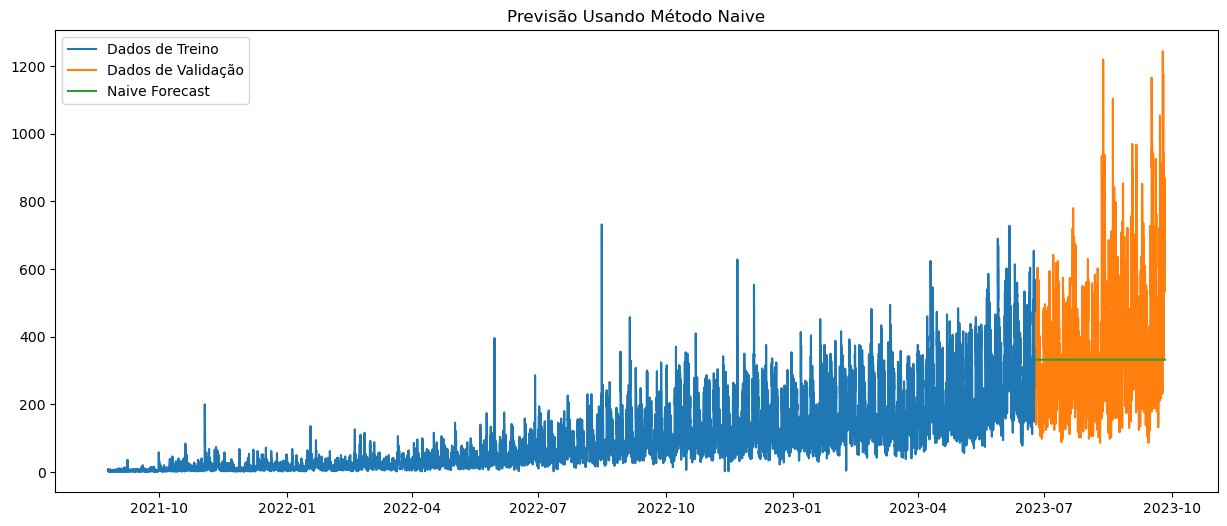

In [43]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Método Naive") 
plt.plot(df_treino.index, df_treino['usuarios_ativos'], label = 'Dados de Treino') 
plt.plot(df_valid.index, df_valid['usuarios_ativos'], label = 'Dados de Validação') 
plt.plot(df_valid_cp.index, df_valid_cp['previsao_naive'], label = 'Naive Forecast') 
plt.legend(loc = 'best') 
plt.show()

Observe que a linha amarela segue uma linha horizontal, sem considerar o padrão de comportamento da série ao longo do tempo. 

Ou seja, a previsão seria apenas um valor geral considerando o último valor dos dados de treino (dados históricos).

Esse é um método muito simples, mas que serve como ponto de partida. Qualquer técnica mais avançada deve apresentar uma performance melhor.

Então vamos trabalhar para criar um modelo robusto nas próximas aulas. Mas antes, vamos calcular a taxa de erro do modelo.

In [44]:
# Define valor real e valor previsto
y_true = df_valid_cp.usuarios_ativos
y_pred = df_valid_cp.previsao_naive

In [45]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

195.06210118417584


RMSE é a taxa de erro e quanto menor, melhor!

In [46]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [47]:
#%watermark -v -m

In [48]:
#%watermark --iversions

# Fim